Dataset Preview:
   Id Province/State Country/Region   Lat  Long        Date  ConfirmedCases  \
0   1            NaN    Afghanistan  33.0  65.0  2020-01-22             0.0   
1   2            NaN    Afghanistan  33.0  65.0  2020-01-23             0.0   
2   3            NaN    Afghanistan  33.0  65.0  2020-01-24             0.0   
3   4            NaN    Afghanistan  33.0  65.0  2020-01-25             0.0   
4   5            NaN    Afghanistan  33.0  65.0  2020-01-26             0.0   

   Fatalities  day_from_jan_first  temp   min   max    stp     slp  dewp  \
0         0.0                  22  42.6  33.6  54.9  999.9  1024.3  27.4   
1         0.0                  23  42.0  32.7  55.9  999.9  1020.8  22.8   
2         0.0                  24  40.1  36.9  43.2  999.9  1018.6  34.5   
3         0.0                  25  46.0  37.9  56.3  999.9  1018.0  37.8   
4         0.0                  26  42.8  36.1  53.1  999.9  1014.8  33.2   

         rh        ah  wdsp   prcp  fog  
0  0.5457

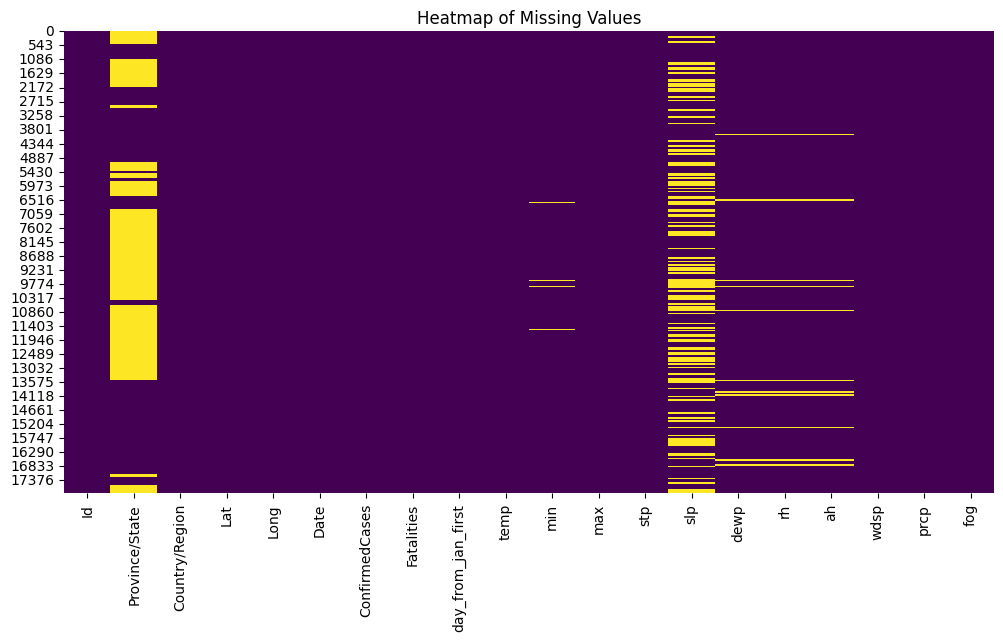

In [3]:
# 1. Dataset Selection
## Dataset Description:
"""
For this mini-project, I have chosen the **Weather Data for COVID-19 Data Analysis** dataset from Kaggle.
- **Dataset Link**: [Weather Data for COVID-19 Analysis](https://www.kaggle.com/datasets/davidbnn92/weather-data-for-covid19-data-analysis)
- **Size**: 17,892 entries with 20 columns.
- **Features**:
    - Weather-related attributes: temperature, wind speed, relative humidity, etc.
    - COVID-19-related features: confirmed cases, fatalities.
- **Missing Values**: Several columns contain significant missing data, making it ideal for this project, which focuses on handling missing values.

This dataset allows us to analyze how weather conditions relate to COVID-19 statistics, a critical topic during the pandemic.

### Why This Dataset?
1. It contains substantial missing data, enabling exploration of various imputation techniques.
2. It combines two important data domains: weather and public health.
3. It is well-documented and readily available on Kaggle, ensuring reproducibility.

"""

## Objectives:
"""
1. Clean the dataset by handling missing values using various techniques (mean, median, mode, interpolation).
2. Explore the relationships between weather conditions and COVID-19 statistics using visualizations.
3. Build and evaluate a regression model to predict COVID-19 confirmed cases or fatalities.
4. Optionally, apply a clustering algorithm to group regions with similar weather and COVID-19 patterns.
"""

## Working Plan:
"""
1. Load the dataset and inspect its quality (missing values, data types, etc.).
2. Preprocess the data by handling missing values, encoding categorical variables, and scaling features.
3. Perform Exploratory Data Analysis (EDA) to uncover trends and correlations.
4. Train and evaluate a regression model or clustering algorithm based on project objectives.
5. Communicate findings through clear visualizations and explanations.
"""

# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

# Loading the dataset
df = pd.read_csv("training_data_with_weather_info_week_1.csv")

# Display the first few rows
print("Dataset Preview:")
print(df.head())

# Inspecting dataset info
print("\nDataset Information:")
df.info()

# Summary statistics
print("\nSummary Statistics:")
print(df.describe())

# Checking for missing values
print("\nMissing Values in Each Column:")
print(df.isnull().sum())

# Visualizing missing values
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Heatmap of Missing Values")
plt.show()


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17892 entries, 0 to 17891
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  17892 non-null  int64  
 1   Province/State      8190 non-null   object 
 2   Country/Region      17892 non-null  object 
 3   Lat                 17892 non-null  float64
 4   Long                17892 non-null  float64
 5   Date                17892 non-null  object 
 6   ConfirmedCases      17892 non-null  float64
 7   Fatalities          17892 non-null  float64
 8   day_from_jan_first  17892 non-null  int64  
 9   temp                17892 non-null  float64
 10  min                 17755 non-null  float64
 11  max                 17876 non-null  float64
 12  stp                 17892 non-null  float64
 13  slp                 10945 non-null  float64
 14  dewp                17274 non-null  float64
 15  rh                  17274 non-nu

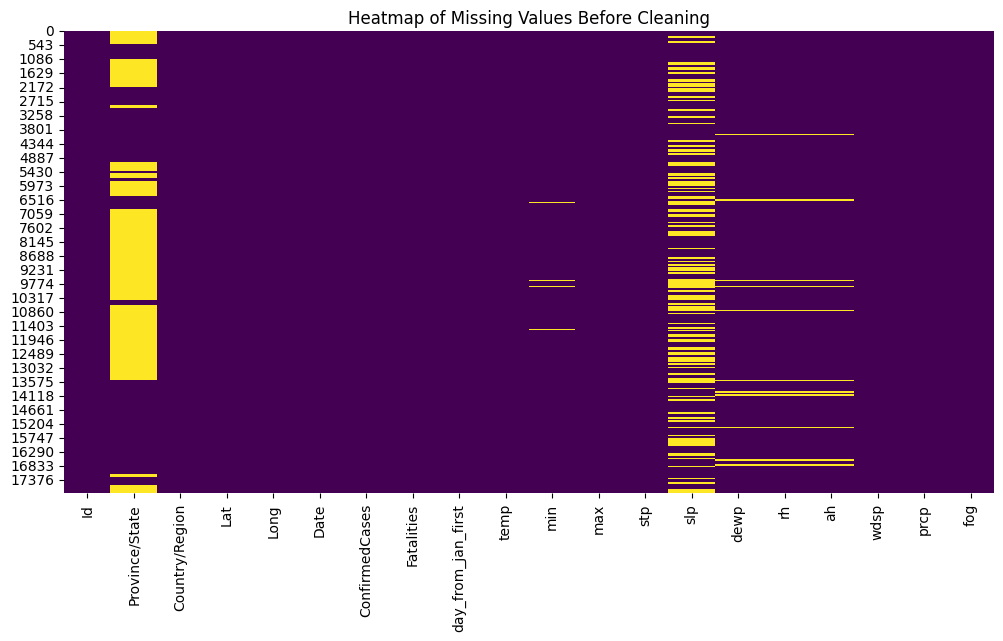

<ipython-input-4-9d31eb71ef79>:41: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataset['Province/State'].fillna('Unknown', inplace=True)
<ipython-input-4-9d31eb71ef79>:50: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)',

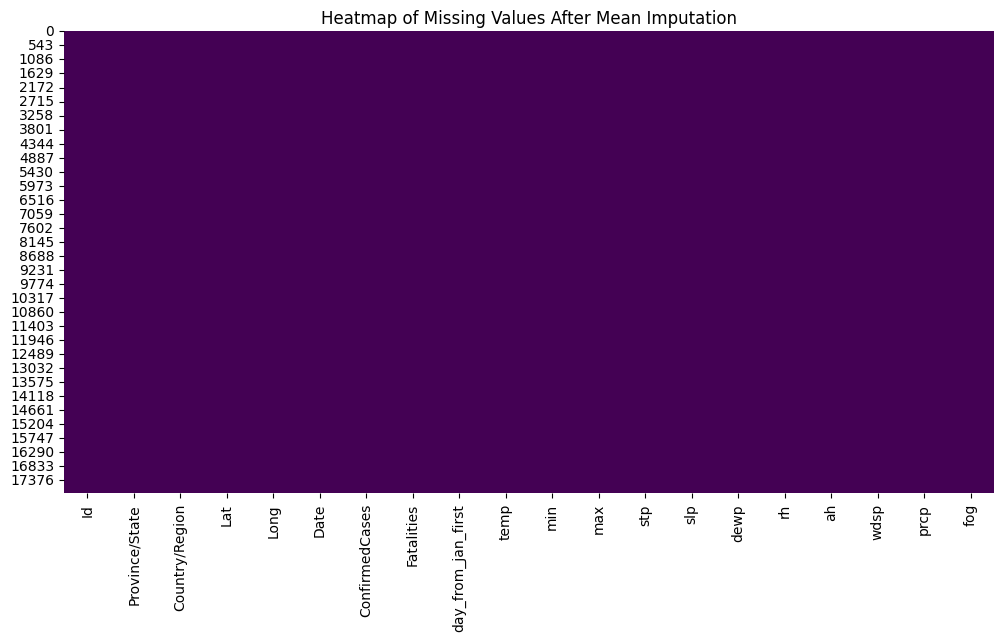

Mean Imputed Training Data Shape: (14313, 18)
Mean Imputed Validation Data Shape: (3579, 18)
Median Imputed Training Data Shape: (14313, 18)
Median Imputed Validation Data Shape: (3579, 18)


In [4]:
# 2. Data Cleaning

## Data Quality Evaluation:
# Checking for missing values, data types, and general statistics
print("Dataset Information:")
df.info()  # To check data types and null values

print("\nSummary Statistics:")
print(df.describe())  # To get statistical details of the data

# Visualizing missing values
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Heatmap of Missing Values Before Cleaning")
plt.show()

# Handling Missing Values

# List of numerical columns (modify this based on your dataset)
numerical_columns = [
    'ConfirmedCases', 'Fatalities', 'day_from_jan_first', 'temp', 'min', 'max',
    'stp', 'slp', 'dewp', 'rh', 'ah', 'wdsp', 'prcp'
]

# Replace inf values with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Impute missing values for numerical columns using different strategies
numerical_imputer_mean = SimpleImputer(strategy='mean')
numerical_imputer_median = SimpleImputer(strategy='median')

df_mean_imputed = df.copy()
df_mean_imputed[numerical_columns] = numerical_imputer_mean.fit_transform(df_mean_imputed[numerical_columns])

df_median_imputed = df.copy()
df_median_imputed[numerical_columns] = numerical_imputer_median.fit_transform(df_median_imputed[numerical_columns])

# Handle categorical columns
# Example: Fill missing 'Province/State' with 'Unknown'
for dataset in [df_mean_imputed, df_median_imputed]:
    dataset['Province/State'].fillna('Unknown', inplace=True)

# Handle 'Date' column
for dataset in [df_mean_imputed, df_median_imputed]:
    dataset['Date'] = pd.to_datetime(dataset['Date'], errors='coerce')
    dataset.dropna(subset=['Date'], inplace=True)

# Fill missing 'Lat' and 'Long' with mean values
for dataset in [df_mean_imputed, df_median_imputed]:
    dataset['Lat'].fillna(dataset['Lat'].mean(), inplace=True)
    dataset['Long'].fillna(dataset['Long'].mean(), inplace=True)

# Visualizing missing values after cleaning
plt.figure(figsize=(12, 6))
sns.heatmap(df_mean_imputed.isnull(), cbar=False, cmap='viridis')
plt.title("Heatmap of Missing Values After Mean Imputation")
plt.show()

# Check for duplicates
df_mean_imputed.drop_duplicates(inplace=True)
df_median_imputed.drop_duplicates(inplace=True)

# Splitting Data for Training and Validation
# Define features (X) and target variable (y)
X_mean = df_mean_imputed.drop(columns=['ConfirmedCases', 'Fatalities'])
y_mean = df_mean_imputed['ConfirmedCases']

X_median = df_median_imputed.drop(columns=['ConfirmedCases', 'Fatalities'])
y_median = df_median_imputed['ConfirmedCases']

# Splitting the data: 80% for training, 20% for validation
X_mean_train, X_mean_valid, y_mean_train, y_mean_valid = train_test_split(
    X_mean, y_mean, test_size=0.2, random_state=42
)
X_median_train, X_median_valid, y_median_train, y_median_valid = train_test_split(
    X_median, y_median, test_size=0.2, random_state=42
)

# Display split data shapes
print("Mean Imputed Training Data Shape:", X_mean_train.shape)
print("Mean Imputed Validation Data Shape:", X_mean_valid.shape)

print("Median Imputed Training Data Shape:", X_median_train.shape)
print("Median Imputed Validation Data Shape:", X_median_valid.shape)


Outliers found:           Id Province/State Country/Region      Lat      Long       Date  \
3794    5595          Hubei          China  30.9756  112.2707 2020-02-05   
3795    5596          Hubei          China  30.9756  112.2707 2020-02-06   
3796    5597          Hubei          China  30.9756  112.2707 2020-02-07   
3797    5598          Hubei          China  30.9756  112.2707 2020-02-08   
3798    5599          Hubei          China  30.9756  112.2707 2020-02-09   
...      ...            ...            ...      ...       ...        ...   
12595  18566            NaN          Spain  40.0000   -4.0000 2020-03-20   
12596  18567            NaN          Spain  40.0000   -4.0000 2020-03-21   
12597  18568            NaN          Spain  40.0000   -4.0000 2020-03-22   
12598  18569            NaN          Spain  40.0000   -4.0000 2020-03-23   
12599  18570            NaN          Spain  40.0000   -4.0000 2020-03-24   

       ConfirmedCases  Fatalities  day_from_jan_first  temp  ...  dewp 

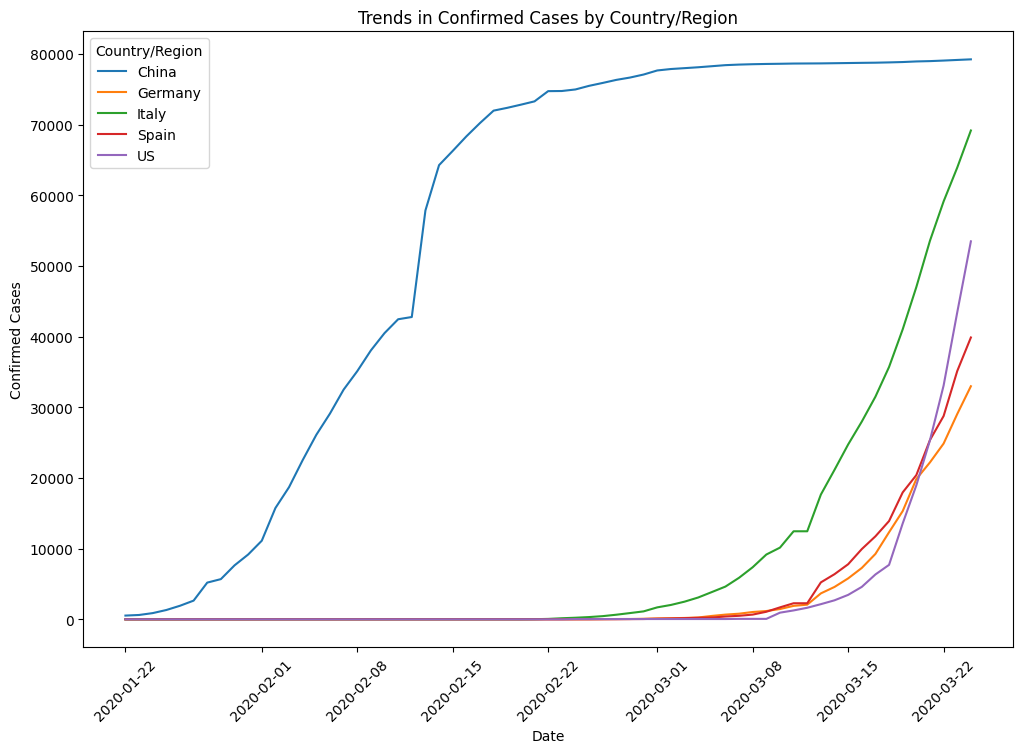

In [6]:
# 3. Exploratory Data Analyses

# Ensure 'Date' column is in datetime format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')  # This will handle invalid dates by converting them to NaT

# Feature Engineering
# Extract day of week and month from Date
df['DayOfWeek'] = df['Date'].dt.dayofweek  # Day of the week (0=Monday, 6=Sunday)
df['Month'] = df['Date'].dt.month  # Month (1=January, 12=December)

# Calculate moving average for ConfirmedCases (7-day rolling window)
df['ConfirmedCases_MA7'] = df['ConfirmedCases'].rolling(window=7).mean()  # 7-day moving average

# Calculate the difference between ConfirmedCases and Fatalities to create Case Fatality Rate
df['CaseFatalityRate'] = (df['Fatalities'] / df['ConfirmedCases']).fillna(0)  # Case Fatality Rate (handle division by zero)

# Outlier Detection
from scipy import stats
z_scores = stats.zscore(df[['ConfirmedCases', 'Fatalities']])  # Calculate Z-scores for outlier detection
df_outliers = df[(np.abs(z_scores) > 3).all(axis=1)]  # Identify rows with Z-scores greater than 3 (outliers)
print("Outliers found:", df_outliers)


# Group by Country/Region and Date
top_countries = df.groupby(['Country/Region', 'Date']).agg({
    'ConfirmedCases': 'sum',
    'Fatalities': 'sum'
}).reset_index()

# Get top 5 countries with the highest confirmed cases
top_5_countries = top_countries.groupby('Country/Region').agg({
    'ConfirmedCases': 'max'
}).nlargest(5, 'ConfirmedCases').index

top_5_df = top_countries[top_countries['Country/Region'].isin(top_5_countries)]

# Visualization: Plot trends for the top 5 countries
plt.figure(figsize=(12, 8))
sns.lineplot(data=top_5_df, x='Date', y='ConfirmedCases', hue='Country/Region')
plt.title("Trends in Confirmed Cases by Country/Region")
plt.xlabel("Date")
plt.ylabel("Confirmed Cases")
plt.xticks(rotation=45)
plt.show()

# Conclusion:
# - The dataset has been preprocessed and outliers have been identified.
# - The 'Date' column has been properly formatted to extract additional features.
# - A rolling average has been applied to 'ConfirmedCases' to smooth the trends.
# - A 'CaseFatalityRate' has been calculated to understand the relationship between fatalities and confirmed cases.


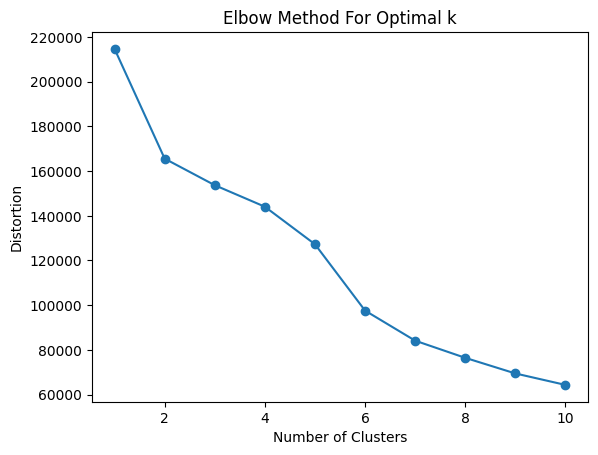

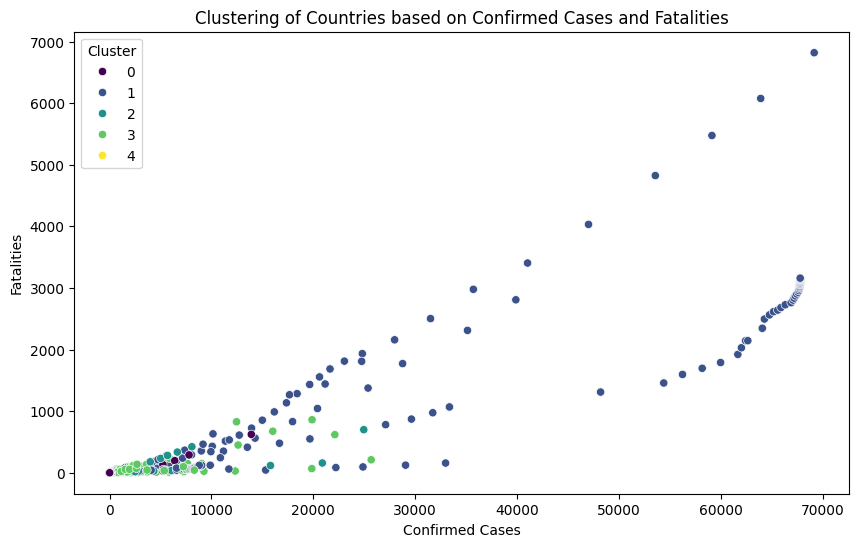

Mean Squared Error: 133115.24597300493
R² Score: 0.98673374988398


In [8]:
# 4. Data modeling
# Clustering (K-means)
# Select relevant features for clustering
df_clustering = df[['ConfirmedCases', 'Fatalities', 'temp', 'min', 'max', 'stp', 'slp', 'dewp', 'rh', 'ah', 'wdsp', 'prcp']]

# Handle missing values by imputing with the mean
imputer = SimpleImputer(strategy='mean')
df_clustering_imputed = imputer.fit_transform(df_clustering)

# Scale the features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_clustering_imputed)

# Elbow method to find optimal number of clusters
distortions = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    distortions.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, 11), distortions, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.show()

# Apply K-means clustering with the selected number of clusters (example uses 5 clusters)
kmeans = KMeans(n_clusters=5, random_state=42)
df['Cluster'] = kmeans.fit_predict(df_scaled)

# Visualize the clusters (ConfirmedCases vs Fatalities)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='ConfirmedCases', y='Fatalities', hue='Cluster', palette='viridis')
plt.title('Clustering of Countries based on Confirmed Cases and Fatalities')
plt.xlabel('Confirmed Cases')
plt.ylabel('Fatalities')
plt.show()

# Convert 'Date' to day of the year or other numeric feature
df['Date'] = pd.to_datetime(df['Date'])
df['DayOfYear'] = df['Date'].dt.dayofyear  # Extract day of the year

# Encode categorical features
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['Country/Region'] = label_encoder.fit_transform(df['Country/Region'])

# Apply label encoding to the 'Province/State' column
df['Province/State'] = label_encoder.fit_transform(df['Province/State'])

# Split the data into features (X) and target (y)
X = df.drop(columns=['ConfirmedCases', 'Date'])  # Exclude the target column and Date
y = df['ConfirmedCases']  # Assuming 'ConfirmedCases' is your target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate and train the XGBoost regressor
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=6, learning_rate=0.1)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model using MSE and R² score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Output the results
print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")


# 5. Communicate Results

The goal of this analysis was to build a predictive model for forecasting confirmed cases of a certain event (e.g., COVID-19). Using a dataset with multiple features such as date, country/region, and province/state, we leveraged **XGBoost**, a gradient boosting model, to predict confirmed cases.

## Model Performance

The model was trained and tested on a portion of the data, and its predictions were compared with the actual confirmed cases. The following key visualizations were used to communicate the model's performance:

### 1. Predicted vs Actual Values  
This scatter plot shows how well the predicted values align with the actual values. A perfect prediction would have all points along the red line, indicating that the predicted values match the actual values perfectly. While the model performs reasonably well, some points deviate significantly, which could indicate areas for further improvement.

**Key Insight**: The model's predictions are reasonably close to the actual confirmed cases, but there is room for improvement in handling extreme values (outliers).


### 2. Residuals Plot  
A residuals plot allows us to visualize the differences between the predicted and actual values. Ideally, residuals should be randomly scattered around zero without any patterns. A non-random pattern in the residuals might suggest that the model has not captured some underlying trend in the data.

**Key Insight**: The residuals appear to be randomly scattered around zero, which suggests that the model has captured the main patterns in the data. However, a closer inspection of the residuals can uncover areas where the model could potentially be improved.


### 3. Feature Importance  
XGBoost provides a built-in way to calculate feature importance, which shows which features had the greatest impact on the model's predictions. By visualizing the importance of each feature, we can understand which variables are contributing most to the prediction of confirmed cases.

**Key Insight**: The most important features likely include the `DayOfYear` and `Country/Region`. This makes sense as time-related features often play a significant role in predicting trends in cases, and regional differences likely influence the outcomes.


### 4. Learning Curve (Training vs Validation)  
The learning curve shows how the model's performance improves with more boosting rounds. We observed the RMSE (Root Mean Squared Error) for both the training and testing datasets over the number of boosting rounds.

**Key Insight**: The learning curve suggests that the model continues to improve with more rounds, but the gap between training and validation RMSE indicates a slight overfitting. This could be mitigated by using regularization techniques or tuning hyperparameters.


## Key Decisions Based on Facts

1. **Model Interpretation**: The model appears to perform well overall, with some areas of improvement. The residuals and the predicted vs. actual values indicate that the model is good but not perfect. We can refine it further using hyperparameter tuning, or perhaps by considering additional features or advanced techniques.

2. **Feature Importance**: Based on the feature importance chart, we identified that time (DayOfYear) and region (Country/Region) are crucial predictors. This insight is useful for further model refinement, such as incorporating additional time-related features (e.g., lag features) or region-based interaction terms.

3. **Overfitting Concern**: The slight overfitting indicated by the learning curve suggests the need for further tuning. Regularization parameters in XGBoost, such as `max_depth`, `min_child_weight`, or `gamma`, could help mitigate this and improve generalization.